# How simple neurons handle non-linearities

### The Universal approximation Theorem

While studying deep learning, coming from a mathematical physics background, I struggled a lot in understanding how a neural network (NN) can fit non-linear functions. Most of the *visual explanations* or tutorials I could find on NNs did not give me a satisfactory explanation as to how a composition of linear functions - i.e. an NN - can handle non-linear behaviour. So I looked for more formal derivations, as I knew that the mathematical foundations of deep learning had to be sound.

Eventually I came across one of the most important papers in this field: **Cybenko (1989, [doi:10.1007/BF02551274](https://link.springer.com/article/10.1007/BF02551274))**. Reading this paper opened my eyes and gave me a completely different perspective on the problem. I realized that the key to the *universal approximation theorem* is that the composition of a linear function and a *sigmoidal* (so-called activation) function yields a series of functions which is dense in the space of continuous functions.

In other words, any continuous function can be written as a finite sum of terms given by the composition of a linear and a sigmoidal function, i.e.
$$
\sum_{i=0}^N \alpha_i\,\sigma({\bf w}_i\cdot{\bf x} + b_i),
$$
with $\sigma: \mathrm{R}\to\mathrm{R}$ being a *sigmoidal* activation function, ${\bf x}\in\mathrm{R}^n$ and ${\bf w}_i\in\mathrm{R}^n$, $\alpha_i,\,b_i\in\mathrm{R}$ $\forall i$.
Cybenko (1989) showed that the set of functions above spans the whole space of continuous functions in $\mathrm{R}^n$, effectively making this set *kind of a* **basis** for $\mathrm{R}^n$, except that the functions are not linearly independent.

Elements of this set of function as in the equation above are usually called *units* or **neurons**.

### Where does the non-linear behaviour come from

Since a neuron is a composition of a linear function with an activation function, the key to approximate non-linear functions is in the *sigmoidal* activation function. Formally a sigmoidal is a function $\sigma: \mathrm{R}\to\mathrm{R}$ such that $\lim_{x\to+\infty} \sigma(x)=1$ and $\lim_{x\to-\infty} \sigma(x)=0$.
<!-- 
$$
\sigma(x) = 
  \begin{cases}
  1\qquad\mbox{as}\;\;x\to+\infty,\\
  0\qquad\mbox{as}\;\;x\to-\infty.
  \end{cases}
$$ 
-->
The Heaviside function is an example of one of the simplest sigmoidal functions; however that is not continuous near $x=0$, thus in practice smooth approximations of it are often used. A popular one is:
$$
\sigma(x)=\frac{1}{1+e^{-x}}
$$

**But how can a linear combination of lines composed with a step function approximate any non-linear behaviour?**
I knew from Cybenko's results that this had to be the case, so I set out and tried to understand and see this better.



## <mark>Part 1:</mark> How many neurons are needed to approximate a given non-linearity?

I asked myself how many neurons (i.e. elements of Cybenko's quasi-basis) would I need to approximate a simple second-order non-linearity, i.e. the function $x\mapsto x^2$.

In [82]:
#| code-fold: true
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

%matplotlib inline
%config Completer.use_jedi = False

Let's generate the data of a nice parabolic curve with some small random noise and let's plot them

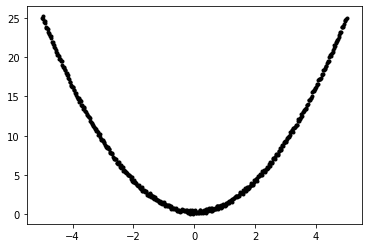

In [2]:
# Training data
size = 500
x = torch.linspace(-5, 5, size)
y = x.pow(2) + 0.5 * torch.rand_like(x)

plt.plot(x,y,'k.')

In order to build some intuition of how we may approximate this data with a linear combination of neurons let's experiment a bit and overplot a few simple combinations of neurons by hand.

First, we need to define our sigmoidal activation function:

In [3]:
sig = lambda x: 1.0/(1.0+np.exp(-x))

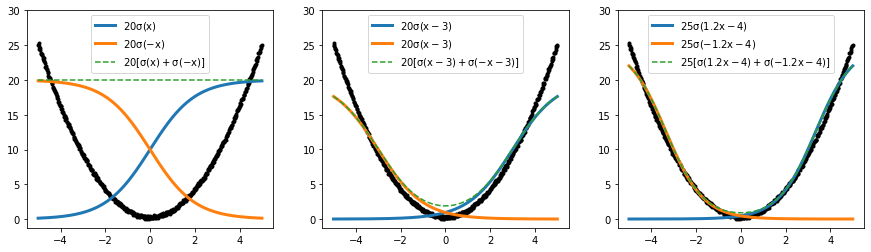

In [4]:
fig,ax = plt.subplots(figsize=(15,4), ncols=3)

def commons(ax):
    ax.plot(x,y,'k.', zorder=0)
    ax.legend(loc='upper center')
    ax.set_ylim((None, 30))


ax[0].plot(x,20*sig(x), lw=3, label=r"$\rm 20\sigma(x)$")
ax[0].plot(x,20*sig(-x), lw=3, label=r"$\rm 20\sigma(-x)$")
ax[0].plot(x,20*(sig(x)+sig(-x)), ls='--', c='tab:green', label=r"$\rm 20[\sigma(x)+\sigma(-x)]$")
commons(ax[0])

ax[1].plot(x,20*sig(x-3), lw=3, label=r"$\rm 20\sigma(x-3)$")
ax[1].plot(x,20*sig(-x-3), lw=3, label=r"$\rm 20\sigma(x-3)$")
ax[1].plot(x,20*(sig(x-3)+sig(-x-3)), ls='--', c='tab:green', label=r"$\rm 20[\sigma(x-3)+\sigma(-x-3)]$")
commons(ax[1])

ax[2].plot(x,25*(sig(1.2*x-4)), lw=3, label=r"$\rm 25\sigma(1.2x-4)$")
ax[2].plot(x,25*(sig(-1.2*x-4)), lw=3, label=r"$\rm 25\sigma(-1.2x-4)$")
ax[2].plot(x,25*(sig(1.2*x-4)+sig(-1.2*x-4)), ls='--', c='tab:green',
           label=r"$\rm 25[\sigma(1.2x-4)+\sigma(-1.2x-4)]$")
commons(ax[2])

These examples help in building up some intuition on how we can use these sigmoidal *building blocks* to approximate relatively simple non linear behaviours. In this specific case of a convex second-order non-linearity, the sum of two scaled, shifted and mirrored step functions seems to yield a decent representation of the data close to the origin.

#### Dependence on the shape of the activation function

Naturally, this is strongly dependent on the particular shape of the sigmoidal function that we chose, i.e. $\sigma: x\mapsto (1+e^{-x})^{-1}$. If we had chosen a Heaviside function instead, the sum of the two neurons above would not have yielded a similarly good approximation of the data.

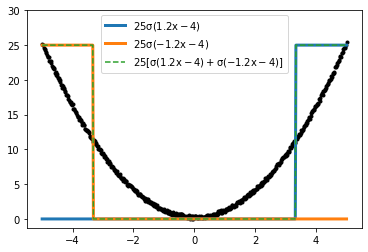

In [91]:
#| code-fold: true
fig,ax=plt.subplots()
ax.plot(x,25*(np.heaviside(1.2*x-4,0.5)), lw=3, label=r"$\rm 25\sigma(1.2x-4)$")
ax.plot(x,25*(np.heaviside(-1.2*x-4,0.5)), lw=3, label=r"$\rm 25\sigma(-1.2x-4)$")
ax.plot(x,25*(np.heaviside(1.2*x-4,0.5)+np.heaviside(-1.2*x-4,0.5)), ls='--', c='tab:green',
        label=r"$\rm 25[\sigma(1.2x-4)+\sigma(-1.2x-4)]$")
commons(ax)

### NN fitting of $x^2$ function

Now that we have some intuition on the linear combinations of neurons let's try to answer the question posed at the beginning of Part 1, that is how many neurons are needed to approximate $x^2$.

To answer this we will build a series of simple `torch` models made up of just one (hidden) layer of neurons, i.e.

`nn.Sequential(nn.Linear(1, N_units), nn.Sigmoid(), nn.Linear(N_units, 1))`


We start by defining a learning rate and a number of epochs; then we loop through the 5 numbers of neurons explored, `[1,2,4,8,16]`, we set up the `nn.Sequential` model and we start the full training loop on the data. We put all of this into a convenient class with a `run` method and a `plots` method, which we use to visualize the output.

In [65]:
#| code-fold: show
class ModelsTestingActivations():
    def __init__(self, activation_fn=nn.Sigmoid(), loss_fn=nn.MSELoss(reduction='sum'), 
                 units=[1,2,4,8,16], learning_rate=3e-2, num_epochs=1000):
        self.activ_fn, self.loss_fn = activation_fn, loss_fn
        self.units, self.lr, self.num_epochs = units, learning_rate, num_epochs
        # outputs
        self.models, self.preds = [], []
        
    def make_model(self, u):
        return nn.Sequential(nn.Linear(in_features=1, out_features=u, bias=True), 
                             self.activ_fn,
                             nn.Linear(in_features=u, out_features=1)
                            )
    
    def plots(self, residuals=True, xextrap=10):
        if not hasattr(self, 'x'): 
            print ('Have you run the model yet?')
            return
       
        fig,ax = plt.subplots(figsize=(18,3.2), ncols=len(self.units))
        for i in range(len(self.units)):
            ax[i].set_xlabel(r'$x$')
            if i==0: ax[i].set_ylabel(r'$y$')
            ax[i].plot(self.x,self.y,'k.')
            ax[i].plot(self.x,self.preds[i],'r.')
            ax[i].plot(np.linspace(-xextrap,xextrap), 
                       self.models[i](torch.linspace(-xextrap,xextrap,50).unsqueeze(1)).detach(), 'b--')
            ax[i].text(0.05,0.05,r"N=%d" % self.units[i], transform=ax[i].transAxes, fontsize=14)

        # residuals
        if not residuals: return
        fig,ax = plt.subplots(figsize=(18,1.6), ncols=len(self.units))
        for i in range(len(self.units)):
            ax[i].set_xlabel(r'$x$')
            if i==0: ax[i].set_ylabel(r'$\Delta y$')
            ax[i].plot(self.x,(self.y-self.preds[i]).abs(), 'k-', lw=0.5)
            ax[i].text(0.5,0.85, r"$\rm \langle\Delta y\rangle=%1.2f$" % (self.y-self.preds[i]).abs().mean(), 
                       transform=ax[i].transAxes, fontsize=12, ha='center', va='center')
    
    def run(self, x, y):
        self.x, self.y = x, y 
        for i,u in enumerate(self.units):
            # define model
            model = self.make_model(u)
            self.models.append(model)

            # define optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)

            # fitting loop
            for epoch in range(self.num_epochs):
                # reinitialize gradient of the model weights
                optimizer.zero_grad()

                # prediction & loss
                y_pred = model(self.x.unsqueeze(-1))
                loss = self.loss_fn(y_pred, self.y.unsqueeze(-1))

                # backpropagation
                loss.backward()

                # weight update
                optimizer.step()

            self.preds.append(y_pred.squeeze().detach())

It is interesting to see how the results of this series of models change depending on which activation function is used, thus we can make our custom class to have as input the shape of the activation function. 

We start with the classic sigmoidal

In [6]:
mods_sigmoid = ModelsTestingActivations(activation_fn=nn.Sigmoid(), units=[1,2,3,4,6], learning_rate=5e-2,
                                        num_epochs=2000)
mods_sigmoid.run(x, y)

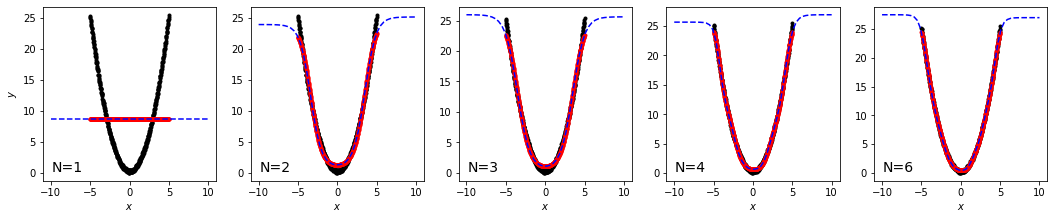

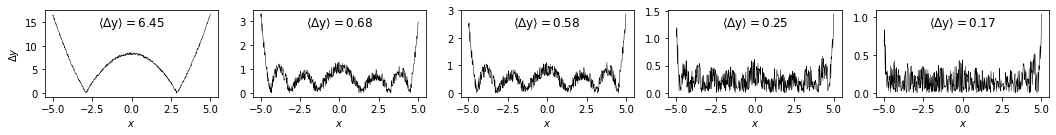

In [307]:
mods_sigmoid.plots()

These plots show how the NN model (red) compares to the actual data used for training (black) as a function of the number (N) of neurons used in the linear layer. Moving from the panels left to right the number of neurons increases from $N=1$ to $N=6$. The dashed blue line is the prediction of the NN model, which we also extrapolated in the range $x\in[-10,10]$ outside of the domain of the data, that are confined within $[-5,5]$.
The rows of panels below show the residuals $\Delta y=|y-y_{\rm NN}|$, i.e. abs(black-red), while $\langle \Delta y \rangle$ is the mean of the residuals.

There are a few interesting things that we can notice:
 - when using only one neuron the NN is able only to capture the mean of the data $\langle y \rangle \approx 8.613$
 - with N=2 neurons, the linear combinations of the two activations is already able to represent the convex 2nd-order non-linearity of the data, reducing the mean residual by an order of magnitude with respect to the model just predicting the mean (i.e. that with N=1).
 - obviously, increasing N results in a better approximation to the training data, for a fixed learning rate and number of training epochs, up to a residual 4x better with N=6 than with N=2.
 - the extrapolations of the NN models outside of the domain of the data do not follow the $x^2$ curve at all, showing that the NN models have successfully learned to reproduce the data, but have not learned completely the behaviour of the underlying curve. This exemplifies that NN models are often poor predictors outside of the domain of the training data

We can have a closer look at the parameters obtained by the NN model with 2 neurons and see how do they compare to the simple fit by eye that we did above. To do this we can grab the `named_parameters` of the model with $N=2$ and print them out

In [7]:
for name, param in mods_sigmoid.models[1].named_parameters():
    if param.requires_grad:
        print (name, param.data)

0.weight tensor([[-1.4160],
        [ 1.4624]])
0.bias tensor([-4.9017, -4.9822])
2.weight tensor([[23.6837, 22.9339]])
2.bias tensor([0.9818])


In [11]:
#| include: false

# Let me now use this piece of code to do a very awkward and ugly refactoring of the parameters above...

mod2_sigmoid = np.zeros(3*mods_sigmoid.units[1]+1)
_p = []
for name, param in mods_sigmoid.models[1].named_parameters():
    if param.requires_grad:
        [_p.append(x.item()) for x in param.data.squeeze().flatten()]
        
for i in range(mods_sigmoid.units[1]):
    mod2_sigmoid[0+i*3] = _p[i] 
    mod2_sigmoid[1+i*3], mod2_sigmoid[2+i*3] = _p[i+mods_sigmoid.units[1]], _p[i+2*mods_sigmoid.units[1]]
mod2_sigmoid[-1]=_p[-1]

#### Let's print out explicitly the function found with $N=2$ neurons

In [25]:
#| code-fold: true
def string_func_mod(x):
    return ("%1.0f sig(%1.1f*x %1.1f) + %1.0f sig(%1.1f*x %1.1f) + %1.1f" %
           (x[2], x[0], x[1], x[5], x[3], x[4], x[6]))

print(string_func_mod(mod2_sigmoid))

24 sig(-1.4*x -4.9) + 23 sig(1.5*x -5.0) + 1.0


Really similar to the parameters we obained by eye! (results may vary a bit due to randomness)

#### Fit with different activation functions

We can also repeat this exercise with different activation functions, e.g. with a softsign

In [337]:
mods_softsign = ModelsTestingActivations(activation_fn=nn.Softsign(), units=[1,2,3,4,6], learning_rate=9e-2,
                                        num_epochs=1000)
mods_softsign.run(x, y)

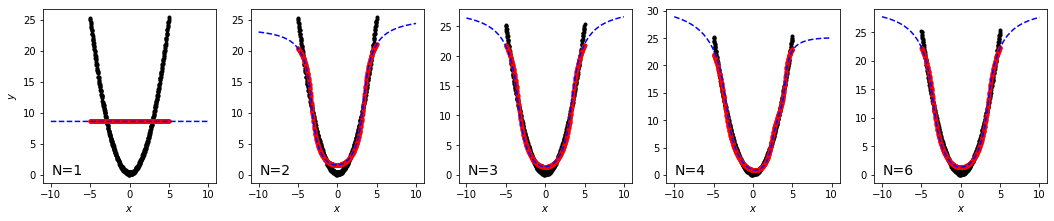

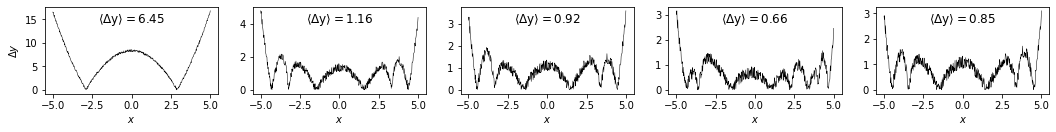

In [338]:
mods_softsign.plots()

or with a ReLU (however, ReLU is not sigmoidal in the sense of Cybenko, so strictly speaking their universal approximation theorem does not apply. It has been shown that the hypothesis on $\sigma$ can be relaxed to it being non-constant, bounded and piecewise continuous, see e.g. Hornik 1991, Leshno et al. 1993)

In [13]:
mods_relu = ModelsTestingActivations(activation_fn=nn.ReLU(), units=[1,2,3,4,6], learning_rate=5e-2,
                                        num_epochs=2000)
mods_relu.run(x, y)

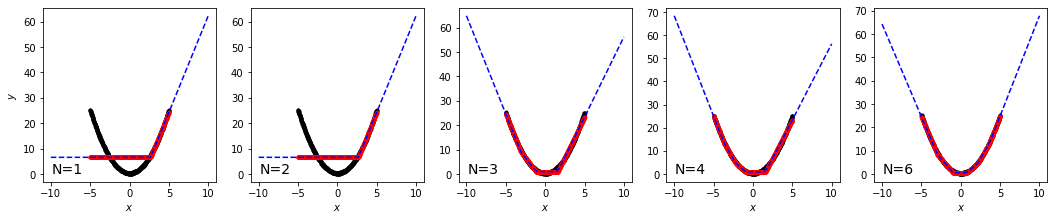

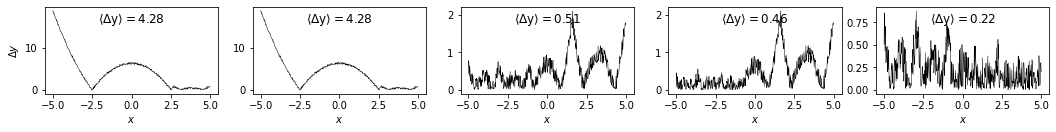

In [14]:
mods_relu.plots()

While the accuracy of the NN with ReLU, as measured by $\langle\Delta y\rangle$, is not significantly better than with Sigmoid for the sake of this experiment, the extrapolation out-of-domain is much better. This is because the NN model with ReLU tends to linear outside of the data domain, while the NN model with Sigmoid is approximately constant outside of the range of the training data.

## <mark>Part 2:</mark> How does this compares with a Bayesian likelihood estimator

It would be interesting to fully reconstruct the likelihood distribution of the parameters of the NN model. If the number of parameters is not huge - that is if we are working with a limited number of neurons in a single layer - then an exploration of the multi-dimensional likelihood distribution is still feasible.
Moreover, if we are able to map the full likelihood of the model parameters we can also see where the best model found by the NN sits in the space of the likelihood.

To do this we can use a Monte Carlo Markov Chain (MCMC) analysis. This is actually what I would normally do when facing an optimization problem in physics, as often one can have a pretty good guess on a suitable functional form to use for the fitting function and, more importantly, this method naturally allows to study the uncertainties on the model found.


We're using the library `emcee` ([paper](https://arxiv.org/abs/1202.3665)) to run the MCMC analysis and `corner` ([paper](https://joss.theoj.org/papers/10.21105/joss.00024)) to plot the posterior distribution. 

In [43]:
#| code-fold: show
import emcee
import corner

# the functional definition of the NN model
def lmod(x, pars):
    """ A linear combination of nu sigmoidals composed with linear functions """
    nu = int((len(pars)-1)/3) # number of neurons, with 2 biases
    res = pars[-1]
    for i in range(nu): res += sig(pars[0+i*3]*x+pars[1+i*3])*pars[2+i*3]
    return res 

# log-likelihood
def lnlike(pars, x, y):
    """ This is equivalent to MSELoss(reduction='sum') """
    y_lmod = lmod(x,pars)
    return -((y-y_lmod).pow(2).sum() / len(y)).item()

# log-prior on the parameters
def lnprior(pars):
    """ A multi-dimensional Gaussian prior with null mean, fixed std and null correlation """
    std = 30
    lp = 0.
    for p in pars: lp += -0.5*(p)**2/std**2-np.log(np.sqrt(2*np.pi)*std)
    return lp

# log-probability = log-likelihood + log-prior
def lnprob(pars, x, y):
    lk, lp = lnlike(pars, x, y), lnprior(pars)
    if not np.isfinite(lp) or not np.isfinite(lk):
        return -np.inf
    return lp + lk

Let's run the MCMC analysis for a $N=2$ NN (see [here](https://emcee.readthedocs.io/en/stable/tutorials/line/) for a bit more context on MCMCs with `emcee`)

In [44]:
nunits = 2
dim = 3*nunits+1

In [45]:
%%time
nu, nw, nstep = 2, 4*dim, 10000

# initial conditions of each chain
pos = [[0]*dim + 1e-4*np.random.randn(dim) for j in range(nw)]

# launch the MCMC
sampler = emcee.EnsembleSampler(nw, dim, lnprob, args=(x.squeeze(), y.squeeze()))
sampler.run_mcmc(pos, nstep);

# collate the chains of each walker and remove the first 500 steps - the burn-in phase
samples = sampler.chain[:,500:,:].reshape((-1, dim))

/Users/lposti/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


CPU times: user 1min 23s, sys: 988 ms, total: 1min 24s
Wall time: 1min 38s


Finally, let's plot the posterior probability distribution of the 7 parameters of a NN model with $N=2$ neurons and let's also mark the location of the model we obtained above with `nn.Sequential`

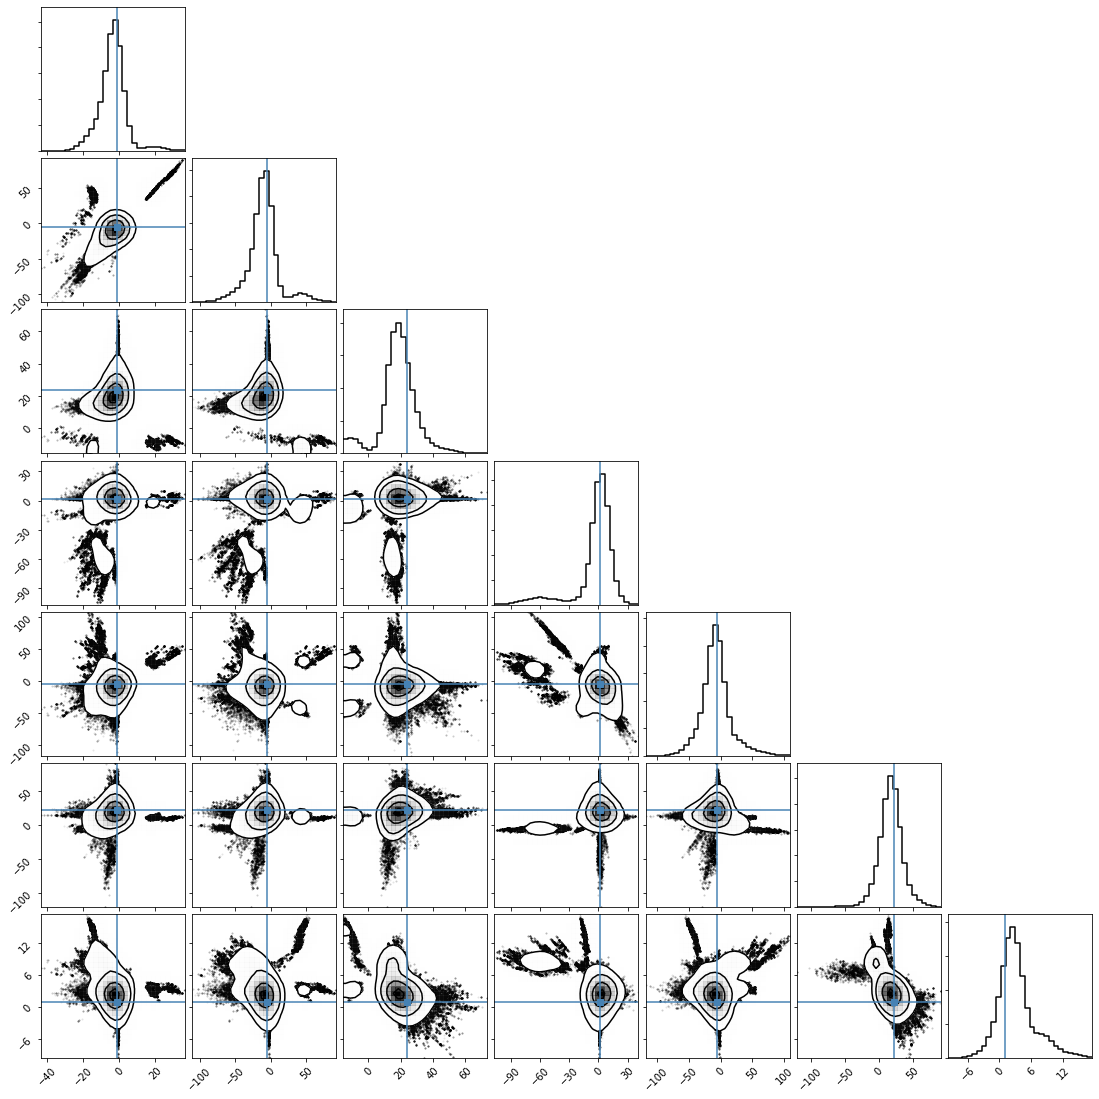

In [46]:
corner.corner(samples, bins=30, smooth=1.5, smooth1d=1.5, truths=mod2_sigmoid);

Find the maximum probability model, i.e. the model with highest log-prob

In [47]:
idmax = np.unravel_index(sampler.lnprobability.argmax(), sampler.lnprobability.shape) # maximum probability
max_prob = sampler.chain[idmax[0],idmax[1],:]

In [48]:
print ('NN model:')
print (string_func_mod(mod2_sigmoid), '    LOSS:%1.2f' % lnlike(mod2_sigmoid, x, y))

print ()
print ('MCMC model')
print (string_func_mod(max_prob), '    LOSS:%1.2f' % lnlike(max_prob, x, y))

NN model:
24 sig(-1.4*x -4.9) + 23 sig(1.5*x -5.0) + 1.0     LOSS:-0.73

MCMC model
28 sig(-1.2*x -4.3) + 31 sig(1.0*x -3.9) + -0.2     LOSS:-0.31


and we can also plot them side by side in comparison to the data

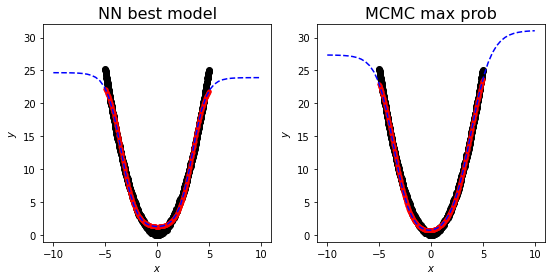

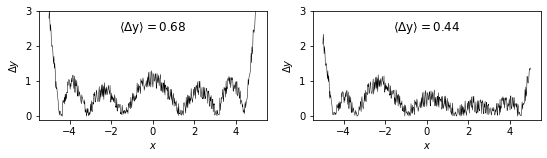

In [59]:
fig,ax = plt.subplots(figsize=(9,4.), ncols=2)

def commons(ax):
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.plot(x,y,'ko')
    ax.set_ylim((-1,32))
    
commons(ax[0])
ax[0].set_title("NN best model", fontsize=16)
ax[0].plot(x, lmod(x, mod2_sigmoid), 'r.')
ax[0].plot(np.linspace(-10,10), lmod(np.linspace(-10,10), mod2_sigmoid), 'b--')

commons(ax[1])
ax[1].set_title("MCMC max prob", fontsize=16)
ax[1].plot(x, lmod(x, max_prob), 'r.')
ax[1].plot(np.linspace(-10,10), lmod(np.linspace(-10,10), max_prob), 'b--')


fig,ax = plt.subplots(figsize=(9,2.), ncols=2)

def commons(ax):
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\Delta y$')
    ax.set_ylim((-0.1,3))
    
commons(ax[0])
ax[0].plot(x, (y-lmod(x, mod2_sigmoid)).abs(), 'k-', lw=0.5)
ax[0].text(0.5,0.85, r"$\rm \langle\Delta y\rangle=%1.2f$" % (y-lmod(x, mod2_sigmoid)).abs().mean(), 
               transform=ax[0].transAxes, fontsize=12, ha='center', va='center');
commons(ax[1])
ax[1].plot(x, (y-lmod(x, max_prob)).abs(), 'k-', lw=0.5)
ax[1].text(0.5,0.85, r"$\rm \langle\Delta y\rangle=%1.2f$" % (y-lmod(x, max_prob)).abs().mean(), 
               transform=ax[1].transAxes, fontsize=12, ha='center', va='center');

## <mark>Part 3:</mark> Dealing with more complex non-linearities

Let's repeat the analysis of Part 1 but for a more complex non-linear function, for instance a sin function with an oscillating non-linear behaviour. Let's now ask ourselves how many neurons would you need to fit this function. 

As before, let's start by generating some data

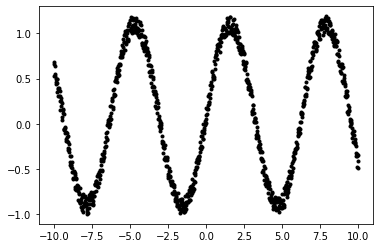

In [62]:
# Training data
size = 1000
x = torch.linspace(-10, 10, size)
y = torch.sin(x) + 0.2 * torch.rand_like(x)

plt.plot(x,y,'k.')

Now we can use the same `ModelsTestingActivations` class that we wrote above, just passing the new xs and ys to the `run` method. Let's use a Sigmoid activation function and let's have a look at the performance of the NN models for increasing number of neurons $N$

In [77]:
mods_sin_sigmoid = ModelsTestingActivations(activation_fn=nn.Sigmoid(), units=[1,2,3,4,6], learning_rate=4e-2,
                                            num_epochs=2000)
mods_sin_sigmoid.run(x, y)

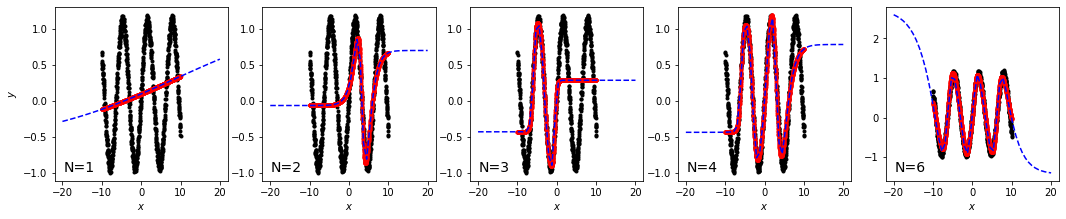

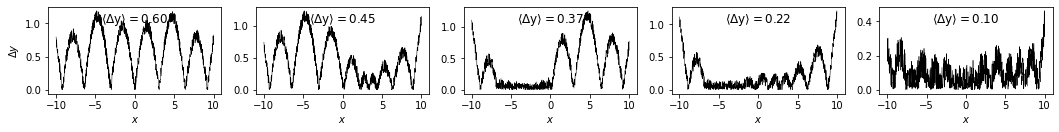

In [78]:
mods_sin_sigmoid.plots(xextrap=20)

From these plots we can clearly notice a few important things:
- the number of neurons limits the number *turnovers* (i.e. changes of sign of the derivative) of the function that can be fitted
- an NN model with $N$ neurons is generally limited to approximate decently only function that change their increasing/decreasing tendency $N$ times
- in this particular example, the sin function turnsover 6 times in the interval $[-10,10]$, thus an NN with at least $N=6$ neurons is needed to capture all the times the data turnover
- also in this case, the extrapolation of the NN models outside of the domain of the data yield poor predictions. This means that the NN has learned to reproduce the data, but has not learned the underlying functional behaivour